#  Interpretable Machine Learning
5/16/2022  
Lei G Renmin Univ. of China

### 1. setup a Xgboost model as example

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import dtreeviz
from sklearn import tree
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'
import os

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('car_prices.csv',on_bad_lines='skip')
df=df.dropna(subset=['sellingprice'])

df_Train,df_Test=train_test_split(df,test_size=0.3,random_state=123)

In [3]:
target='sellingprice'
ytrain=df_Train[target].copy()
ytest=df_Test[target].copy()
print(ytrain.shape,ytest.shape)
var_list=['year', 'condition', 'odometer', 'mmr' ]
xtrain=df_Train[var_list]
xtest=df_Test[var_list]

(391167,) (167644,)


In [4]:
xtrain.columns

Index(['year', 'condition', 'odometer', 'mmr'], dtype='object')

In [5]:
xtrain.columns

Index(['year', 'condition', 'odometer', 'mmr'], dtype='object')

In [41]:
%%time
hyperparameters_xgb={'n_estimators':200,
                     'learning_rate':0.1,
                     'max_depth':5,
                     'n_jobs':-1,
                     #'monotone_constraints':(1,1,-1,1)
                    }
reg_xgb=XGBRegressor(**hyperparameters_xgb)
reg_xgb.fit(xtrain,ytrain)
ypred_xgb = reg_xgb.predict(xtest)

Wall time: 58.3 s


In [42]:
df_Test['pred_price_xgb']=ypred_xgb
df_Test['error_xgb']=(df_Test['pred_price_xgb']-df_Test['sellingprice'])/df_Test['sellingprice']

df_Test['error_xgb'].abs().mean()

0.2629769662810577

### 2. Feature Importance

##### Permutation Importance

In [43]:
import eli5 
from sklearn.inspection import permutation_importance
from eli5.sklearn import PermutationImportance

#perm_importance =permutation_importance(reg_xgb, xtest_ann,ytest_ann,random_state=1)
perm_importance2 =PermutationImportance(reg_xgb,random_state=1,
                                        scoring='neg_mean_absolute_error',n_iter=5
                                       ).fit(xtest,ytest)
eli5.show_weights(perm_importance2, feature_names = xtest.columns.tolist())

Weight,Feature
8568.2073 ± 29.1623,mmr
532.0077 ± 3.6529,condition
297.0367 ± 3.1692,odometer
150.3402 ± 2.3889,year


##### Weight Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

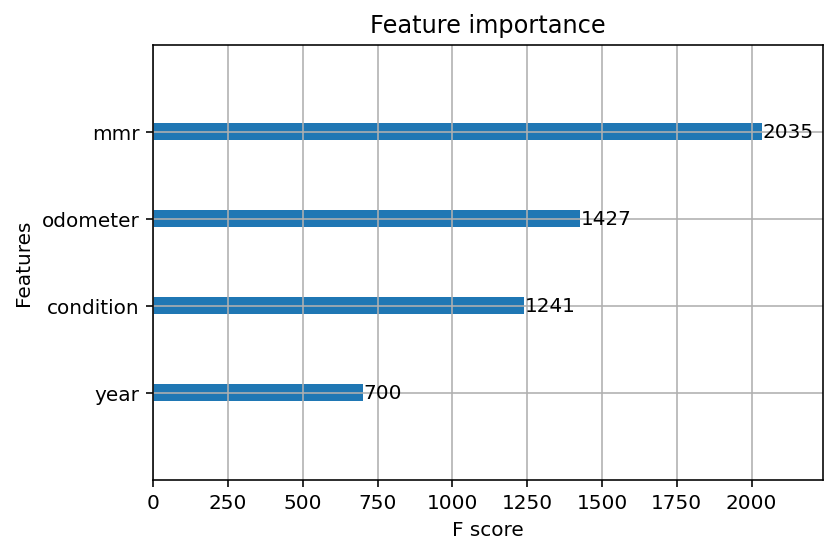

In [44]:
xgb.plot_importance(reg_xgb,importance_type='weight')

##### Gain Value Feature Importance

In [45]:
reg_xgb._Booster.get_score(importance_type='gain')

{'mmr': 92584895588.92783,
 'condition': 1198651659.1711824,
 'odometer': 205113715.71041843,
 'year': 129266769.61937289}

In [46]:
ft_impt_xgb=reg_xgb._Booster.get_score(importance_type='gain')

ft_impt_xgb=pd.DataFrame(ft_impt_xgb.items(),columns=['feature','ft_importance_gain'])

ft_impt_xgb['ft_importance_gain_pct']=ft_impt_xgb['ft_importance_gain']\
/ft_impt_xgb['ft_importance_gain'].sum()

display(ft_impt_xgb)

,feature,ft_importance_gain,ft_importance_gain_pct
0,mmr,9.258490e+10,0.983712
1,condition,1.198652e+09,0.012736
2,odometer,2.051137e+08,0.002179
3,year,1.292668e+08,0.001373


Text(0.5, 1.0, 'Gain Value Feature Importance')

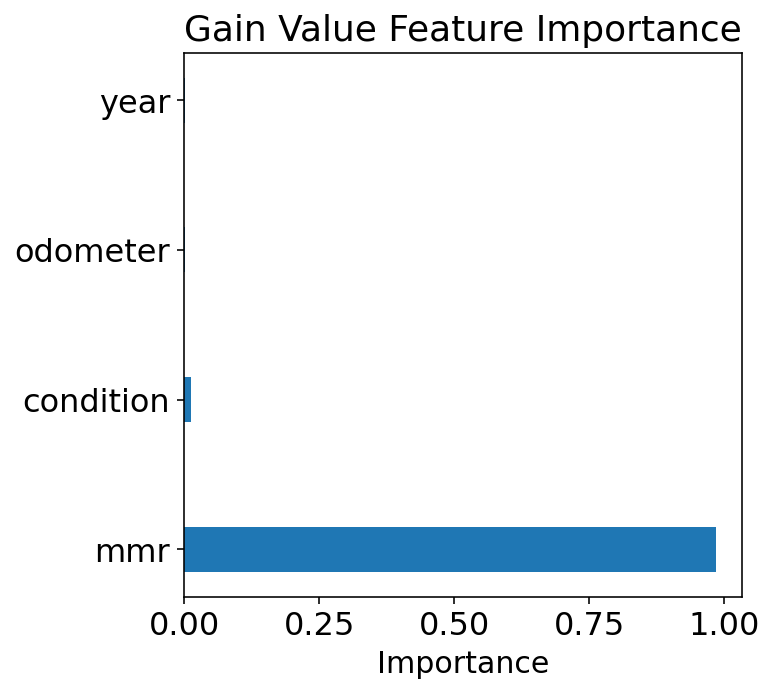

In [47]:
fig,ax=plt.subplots(figsize=(5,5))
ax.barh(ft_impt_xgb['feature'],ft_impt_xgb['ft_importance_gain_pct'],height=0.3)
ax.tick_params(axis='both',labelsize=16)
ax.set_xlabel('Importance',fontsize=15)
ax.set_title('Gain Value Feature Importance',fontsize=18)

##### Plot the shape of the decision tree

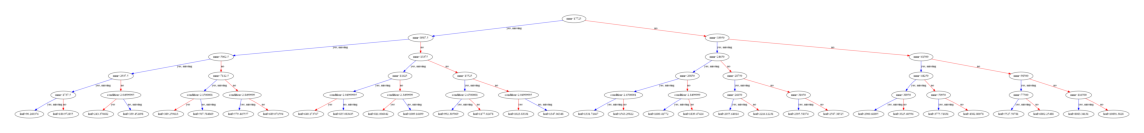

In [48]:
fig,ax=plt.subplots(figsize=(10,10))
xgb.plot_tree(reg_xgb,ax=ax,num_trees=2)
fig.savefig('xgboost_tree.png',dpi=800)

### 3. Partial Dependence Plot

In [49]:
from sklearn.inspection import plot_partial_dependence, partial_dependence


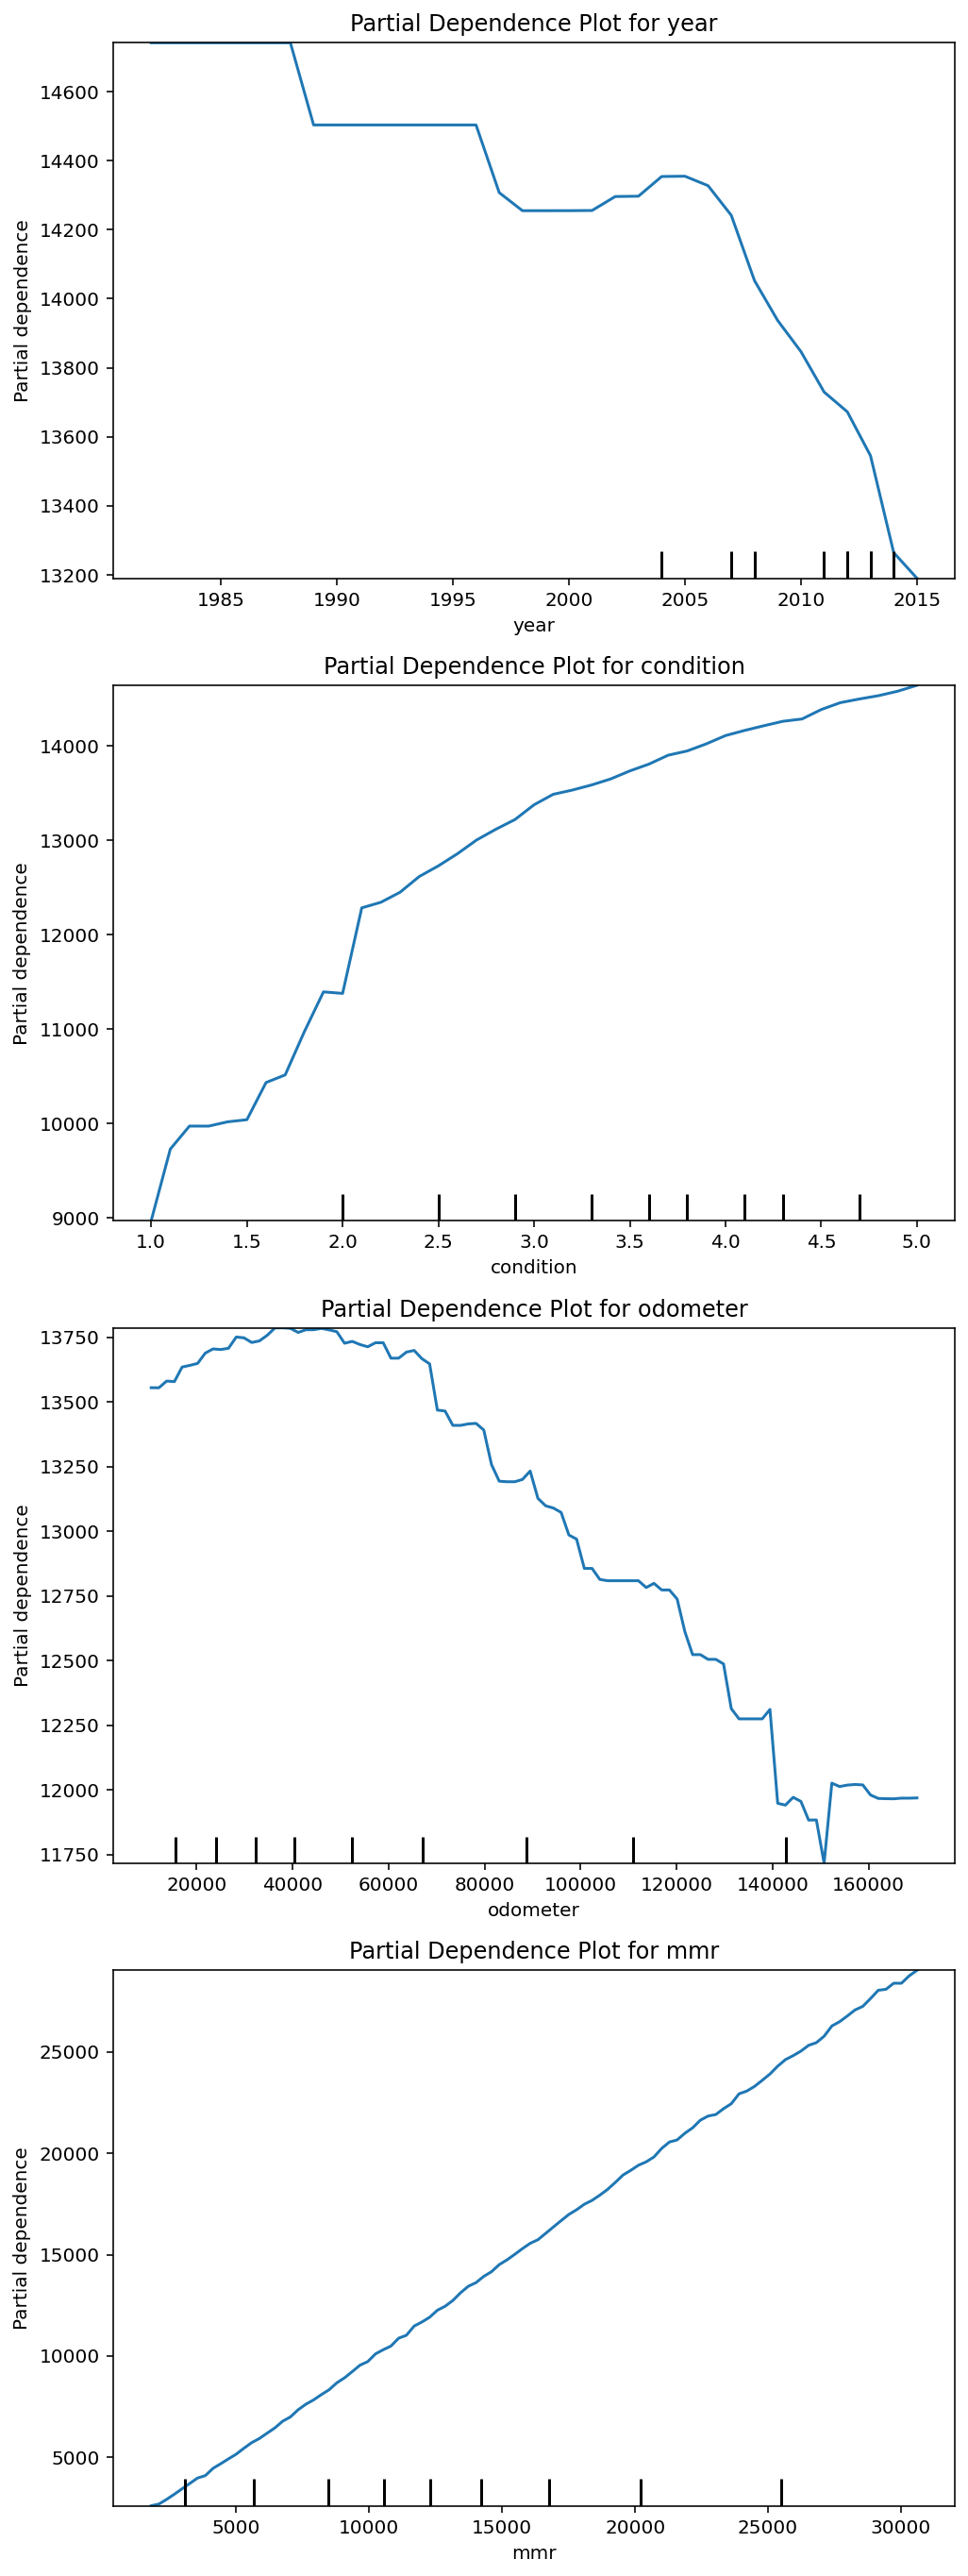

In [50]:
n_col=len(xtrain.columns)

fig, ax = plt.subplots(n_col,1,figsize=(8, 6*n_col))
i=0
for col in xtrain.columns:
    ax[i].set_title(f"Partial Dependence Plot for {col}")
    plot_partial_dependence(
        estimator=reg_xgb,
        X=xtrain,
        features=[col],
        kind='average',
        ax=ax[i],
    )
    i+=1

In [51]:
xtrain.columns

Index(['year', 'condition', 'odometer', 'mmr'], dtype='object')

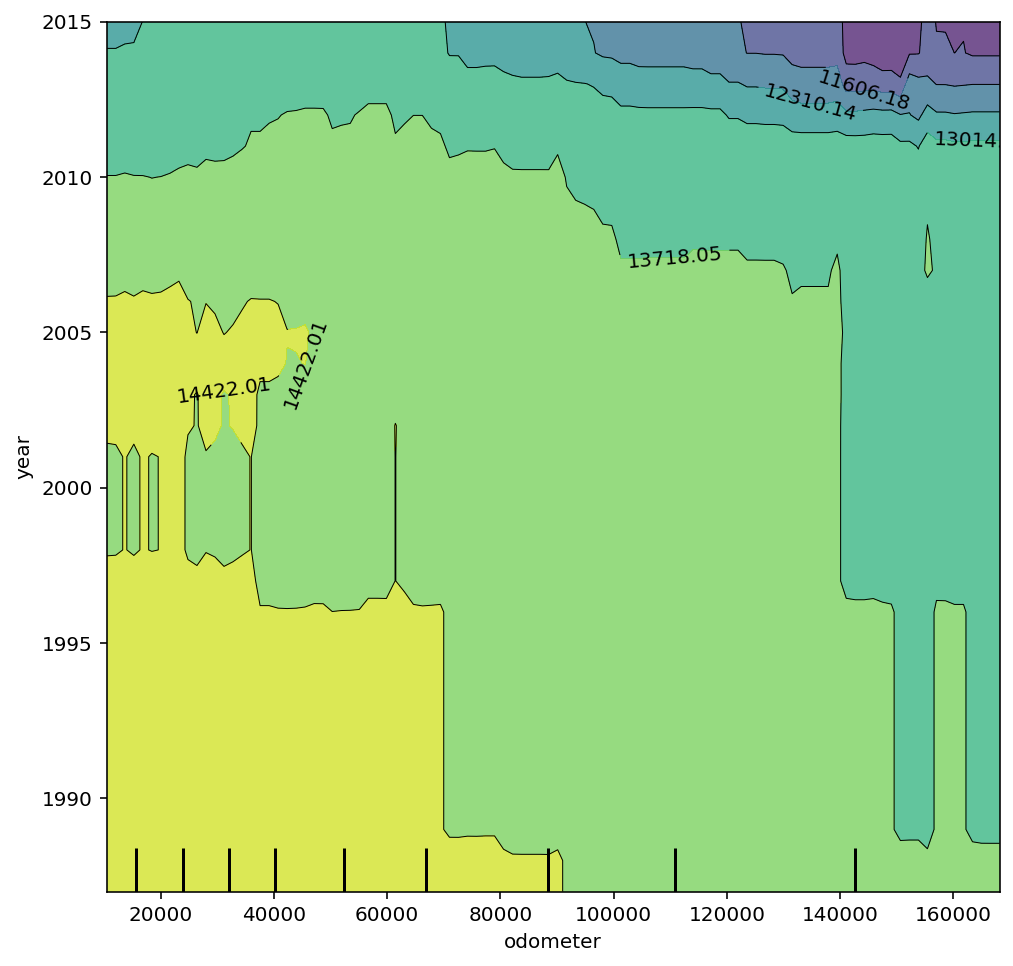

In [52]:
fig2,ax2=plt.subplots(figsize=(8,8))
plot_partial_dependence(
        estimator=reg_xgb,
        X=xtrain.sample(frac=0.05),
        features=[('odometer','year')],
        kind='average',
    ax=ax2
    )

In [53]:
pd3d_data=partial_dependence(
        estimator=reg_xgb,
        X=xtrain.sample(frac=0.05),
        features=[(1,2)],
        kind='average'
    )

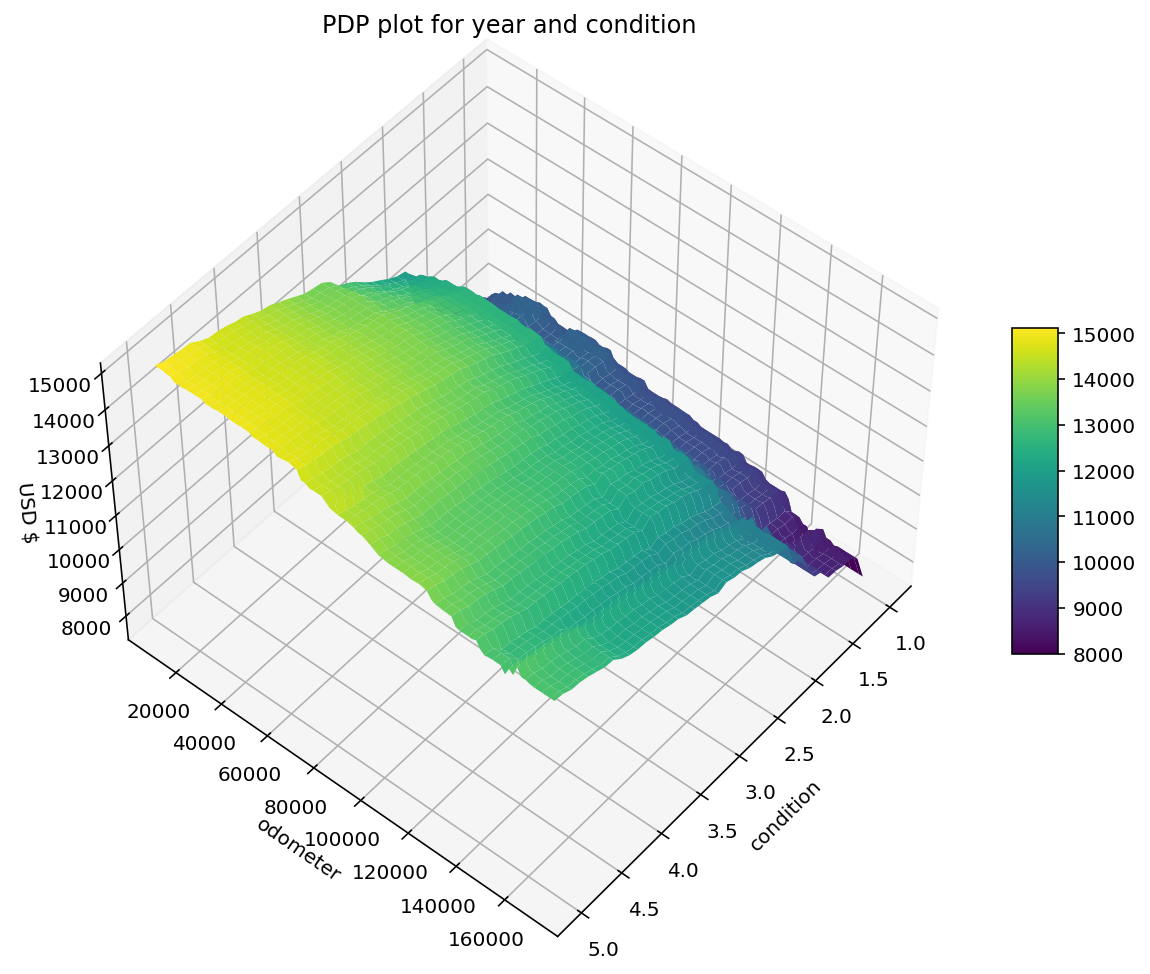

In [89]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

X, Y = np.meshgrid(pd3d_data['values'][0], pd3d_data['values'][1])
Z =np.transpose(pd3d_data['average'][0])

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ='3d')
surf=ax.plot_surface(X, Y, Z,cmap ='viridis',)
ax.set_title('wireframe geeks for geeks')
ax.set_xlabel('condition')
ax.set_ylabel('odometer')
ax.set_zlabel('USD $')
ax.tick_params(axis='both',labelsize=10)
ax.set_title('PDP plot for year and condition')
ax.view_init(50, 40)
fig.colorbar(surf, ax = ax, shrink = 0.3, aspect = 7) 


In [90]:
fig.savefig('pdp3d.png',dpi=300)